<h1 align="center">Localisation optimale des capacités de production éoliennes en Europe</h1> 
<h2 align ="center"> LINMA1702 : Modèles et méthodes d'optimisation </h2>
<h3 align = "center">  Boucquey Matthieu - Chung Anthony - Lovat Louis </h3>
<h3 align= "center"> Avril 2020 </h3>

<p>Dans le contexte de la transition énergétique, on souhaite étudier un scénario où une partie significative de la production d’électricité en Europe serait assurée par de l’énergie éolienne, produite sur des sites onshore ou offshore. Vu la variabilité de ce type de production, on a pour objectif d'analyser et dès lors de déterminer parmi le sites éoliens à quels endroits et avec quelle capacité il faudrait installer des éoliennes pour obtenir la plus grande production d’énergie possible étant donné : les données récoltée sur une année et les hypothèses et contraintes mentionnées ci-dessous.</p>

In [7]:
import numpy as np

from cylp.cy import CyClpSimplex
from cylp.py.modeling.CyLPModel import CyLPArray, CyLPModel

import matplotlib.pyplot as plt
import math 
import pandas as pd
import plotly.graph_objects as go
import matplotlib.colors as colors
import random

colors_list = list(colors._colors_full_map.values())
random.shuffle(colors_list)

%matplotlib notebook

<h1> Partie I. Analyse d'un modèle européen intégré </h1>

On cherche alors à maximiser l’énergie totale qui sera produite par ces installations au cours d’une année 

<h2> Données et Hypothèses</h2> 
Simulation
<ul>
    <li>642 sites éoliens avec une instalation de puissance comprise entre 0 et la capacité maximale respective
    <li>production d'énergie heure pas heure sans variation à l'intérieur d'une heure
    <li> Rendement heure par heure sur un année complète 
    <li> INstallation d'une puissance P à travers l'Europe sans distinguer pays par pays 
    <li> Desire avoir une fraction de la production égale à kappa P sur les sites offshores
    <li> ON desire une vaiabilité moyenne inférieur à delta P T 
    <li> travaille  sur des pas de temps égale à T 
          
</ul>

In [8]:
## paramètres

liste_pays = ['Allemagne','Autriche','Belgique','Danemark','Espagne','France','Irlande','Italie','Luxembourg',\
             'Norvège','Pays-Bas','Portugal','Royaume-Uni','Suède','Suisse']

liste_pays_index_dic = {'Allemagne':0,'Autriche':1,'Belgique':2,'Danemark':3,'Espagne':4,'France':5,'Irlande':6,'Italie':7,'Luxembourg':8,\
             'Norvège':9,'Pays-Bas':10,'Portugal':11,'Royaume-Uni':12,'Suède':13,'Suisse':14}

list_colors_dic = {'Allemagne':colors_list[0],'Autriche':colors_list[1],'Belgique':colors_list[2],'Danemark':colors_list[3],'Espagne':colors_list[4],\
                         'France':colors_list[5],'Irlande':colors_list[6],'Italie':colors_list[7],'Luxembourg':colors_list[8],\
             'Norvège':colors_list[9],'Pays-Bas':colors_list[10],'Portugal':colors_list[11],'Royaume-Uni':colors_list[12],'Suède':colors_list[13],'Suisse':colors_list[14]} 

TURB = np.array([8587 , 12009 , 1417 , 9 , 18372 , 25132 , 527 , 21117 , 1140 , 28941 , 37 , 5052 , 4269 , 16637 , 15101])
POMP = np.array([5223 , 3580 , 1307 , 0 , 5347 , 4303 , 292 , 7544 , 1100 , 1396 , 0 , 1029 , 2744 , 45 , 1636 ])
RES = np.array([0.3*1e6 , 3.2*1e6 , 0.01*1e6 , 0 , 18.4*1e6 , 9.8*1e6 , 0.24*1e6 , 7.9*1e6 , 0.005*1e6 , 84.147*1e6 , 0 , 2.6*1e6 , 1.2*1e6 , 33.756*1e6 , 8.4*1e6])

N_pays = 15                  # plus petit ou égal à N_pays_max = 15
N_sites = 642                # plus petit ou égal à sites_max = 642
N_heures_par_annee = 24*365  # nombre d'heures par année
N_annees = 1/12              # fraction de l'annee à utiliser ; prendre par exemple 1/12 pour tester sur un mois (calculs 
                             # plus rapides) ; dans le rapport il faut utiliser l'année complète N_annees = 1
#N_heures = int(np.ceil(N_heures_par_annee*N_annees)) # nombre d'heures à extraire des fichiers de rendements
N_heures = 732

In [9]:
### chargement et traitement des données brutes (I) ###
sites = pd.read_csv('Sites.csv', index_col = "index site").sort_index()

sites_onshore = sites[sites['capacite offshore']=='Non'].copy()
sites_offshore = sites[sites['capacite offshore']=='Oui'].copy()

# Arrays comprenants respectivement les indices des sites offshore et onshore
indice_onshore= np.array(sites_onshore.index)
indice_offshore= np.array(sites_offshore.index)

In [10]:
### chargement et traitement des données brutes (II) ###
rend_offshore_brut = np.genfromtxt('Rendements_offshore.csv', delimiter=',')[:,:N_heures]
rend_onshore_brut = np.genfromtxt('Rendements_onshore.csv', delimiter=',')[:,:N_heures]

# Matrice combinant les valeurs des rendements pour les sites onshore et offshore 
rend_sites_matrix = rend_onshore_brut.copy()   
rend_sites_matrix[indice_offshore] = rend_offshore_brut[indice_offshore]

<h2> Question I.1. : Modélisation du problème d'optimisation </h2>

<h3> Données </h3> 

 - $ \eta : \text{Matrice des rendements dans laquelle chaque ligne correspond à un site et chaque colonne à une heure}$
    
 - $ N_{sites} : \text{ Nombre de sites sur lesquels se porte notre étude.}$
 - $ N_{heures} : \text{ Période sur laquelle se porte notre étude en heure.} $
 - $ P : \text{ Puissance totale à installer en MW.}$

 - $ T : \text{ Pas de temps pour l'étude de la variabilité.}$
 - $ \delta  : \text{ Ratio toléré entre deux périodes de temps T consécutives.}$

 - $ \kappa : \text{ Proportion de production se faisant en site offshore.}$

### Variables

 - $p^{installée} : \text{Vecteur des puissances intsallées sur chaque site.}$
 - $v : \text{Vecteur des variables intermédiaires permettant la retranscription des contraintes en valeur absolue.}$

### Objectifs 

$
\text{max } \sum_{i=1}^{N}p_{i}^{installée}\sum_{j=1}^{N_{heures}}\eta_{ij}
$

Pour nous adapter aux spécifications du module CyLP nous avons transformé notre max en min comme suit:

$
\text{min } \sum_{i=1}^{N}p_{i}^{installée}(-\sum_{j=1}^{N_{heures}}\eta_{ij})
$

### Contraintes

- $ \sum_{i=1}^{N} p_{i}^{installée} = P $
- $
\sum_{i=1}^{N} \alpha_{i} p_{i}^{installée} = \kappa P 
\text{ , avec : }
\begin{align}
\begin{cases}
\alpha_{i} = 1 & \text{ si $i$ est l'indice d'un site offshore}\\
\alpha_{i} = 0 & \text{ si $i$ est l'indice d'un site onshore}
\end{cases}
\end{align}
$

 - $ 
\sum_{i=1}^{\frac{N_{heures}}{T}-1} \frac{\sum_{j=1}^{N}p_{j}^{installée}|\sum_{k=Ti+1}^{Ti+T} \eta_{jk}-\sum_{k=Ti+T+1}^{Ti+2T}\eta_{jk}|}{\frac{N_{heures}}{T}-1} \leq \delta P
$ 

    $\begin{align}
\Leftrightarrow
\begin{cases}
    \sum_{j=1}^{N}p_{j}^{installée}\sum_{k=Ti+1}^{Ti+T} \eta_{jk}-\sum_{k=Ti+T+1}^{Ti+2T}\eta_{jk} - l & \leq 0\\
    \sum_{j=1}^{N}p_{j}^{installée}(-\sum_{k=Ti+1}^{Ti+T} \eta_{jk}+\sum_{k=Ti+T+1}^{Ti+2T}\eta_{jk}) - l & \leq 0\\
    \sum_{i=1}^{\frac{N_{heures}}{T}-1} l_{i} & \leq \delta P n_{interval}\\
\end{cases}
\end{align}
$


 - $ p^{installée} \geq 0 $

Nous résolvons par la méthode du simplex primal et imprimons les valeurs de nos variables ainsi que de notre fonction objectif à l'optimum. 

### Taille du modèle

<u>Nombre de variables</u>: $\mathcal{O}( N_{sites} + N_{heures}/ T )$
<ul>
    <li> Puissance installée : $N_{sites}$
    <li> Variables de linéarisation : $N_{heures} / T$
</ul>

<u>Nombre de contraintes</u> : $\mathcal{O}( N_{sites} + N_{heures}/ T )$
<ul>
    <li> Capacité des sites de production : $2* N_{sites}$
    <li> Puissance à installer : $1$
    <li> Puissance à installer sur les sites offshore : $1$
    <li> Variabilité moyenne : $(2*N_{heures})/T $
</ul>
Le nombre de variables et le nombre de contraines varient de manière proportionnelle , on en conclue que la taille de notre modèle est en  $\mathcal{O}( N_{sites} + N_{heures}/ T )$.

<h2> Question I.2. Résolution numérique par la méthode du simplexe </h2>

In [17]:
#TODO contraince active, variable =0

def attribution_puissance(P = 500000, κ = 0.17, δ = 0.02, T = 3):
    """ attribution_puissance est une fonction qui, à l'aide d'un algorithme du simplex 
        et de données sur des sites de production éoliens d'énergie, répartit, de manière 
        à obtenir une production d'énergie maximale, un capital de puissance à installer 
        parmi les sites disponibles.
        
        (input)
         - P [int] : Puissance à répartir parmi les sites (en [MWh])
         - kappa [float] : Proportion de la contribution des sites offshore 
         - delta [float] : Coefficient borne la variabilité de la production d'énergie
         - T [int] : Pas de temps considéré pour la contrainte de variabilité (en [heure])
         
        (output)
         - p_inst [numpy array] : Vecteur de dimension (N_sites, 1) reprenant les attributions
           de puissance à installer par site
         - E_tot [float] : Valeur maximisée de l'énergie totale produite (en [MWh])
         - status [string] : Contient l'état de la solution
         - l_sol [numpy array] : Vecteur de longueur N_heures//T-1 comprenant les bornes associées 
           à chaque valeur absolue de la variabilité
         - dual_sol [dict] : Dictionnaire ayant pour valeurs les solutions du probleme dual et
           pour clés le nom des contraintes du primal associées à celles-ci
         - dual_coutsreduits [numpy array] : Vecteur de taille N_sites reprenant les coûts réduits 
           du problème dual
    """
    
    ## Création object CyClpSimplex ##
    s = CyClpSimplex()
    
    ## Ajout des variables ##
    puiss = s.addVariable('Puissance installee', N_sites) 
    L = s.addVariable('l', N_heures//T -1) 
    
    ## Fonction objectif ##
    rend_somme = rend_sites_matrix.sum(axis = 1)
    s.objective = CyLPArray(-rend_somme)*puiss
    
    ## Ajout des contraintes##
    
    #~ Contrainte 1 : Capacité des sites de production ~#
    sites_capacite_max = CyLPArray(sites["capacites"])
    s.addConstraint(0 <= puiss <= sites_capacite_max, "Contrainte capacite max")
    
    #~ Contrainte 2 : Puissance à installer ~#
    s.addConstraint(puiss.sum() == P,"Puissance à installer")
    
    #~ Contrainte 3 : Puissance à installer sur les sites offshore ~#
    s.addConstraint(puiss[indice_offshore].sum() - κ*puiss.sum() == 0,"Puissance offshore à installer")
     
    #~ Contrainte 4 : Variabilité moyenne (non-cyclique) de la puissance produites sur intervalles de temps ~#
    s.addConstraint(L.sum() <= δ*P*(N_heures//T-1)*T,"Variabilité")
    
    rend_sites_par_intervalle = np.sum(rend_sites_matrix.reshape(N_sites, N_heures//T, T), axis = 2)
    diff_rend = np.asmatrix(rend_sites_par_intervalle[:,1:] - rend_sites_par_intervalle[:,:-1]).T
    
    s.addConstraint(diff_rend*puiss - L <= 0, "Abs contrainte 1")
    s.addConstraint(-diff_rend*puiss - L <= 0, "Abs contrainte 2")

    """#~ Contrainte 4bis : Variabilité moyenne (cyclique) de la puissance produites sur intervalles de temps ~#
    s.addConstraint( L.sum() <= δ*P*(N_heures//T)*T,"Variabilité")
    
    rend_sites_par_intervalle = rend_sites_matrix.reshape(N_sites, N_heures//T, T).sum(axis = 2).T
    rend_sites_par_intervalle_decalle = np.roll(rend_sites_par_intervalle.copy(), 1, axis = 1)
    diff_puiss = np.asmatrix(rend_sites_par_intervalle_decalle - rend_sites_par_intervalle)*puiss

    s.addConstraint(0 <= L - diff_puiss, "Abs contrainte 1")
    s.addConstraint(0 <= L + diff_puiss, "Abs contrainte 2")"""
    
    ## Résolution problème d'optimisation via l'algorithme du simplexe ##
    s.primal()    
    
    ## Valeur à retourner ##
    p_inst = s.primalVariableSolution['Puissance installee']
    E_tot = -s.objectiveValue
    status_sol = s.getStatusString()
    l_sol = s.primalVariableSolution['l']
    dual_sol = s.dualConstraintSolution
    dual_coutsreduits = s.dualVariableSolution['Puissance installee']
    
    return p_inst, E_tot, status_sol, l_sol, dual_sol, dual_coutsreduits

In [45]:
#TODO variabilité des best sites (Est -ce que les best sites sont compatible savec la notion de variabilité 
#     ou alor est-ce qu'ils sont tres tres bons sur toutes l'année mais produisent beaucoup de maniere tres instable )

dict = {}
for i in range(len(rend_sites_matrix)):
    dict[i] = rend_sites_matrix[i].sum()

dict_sorted = sorted(dict.items(), key=lambda x: x[1],reverse=True)
dict_best = dict_sorted[:10]

index_best = np.zeros(10)
rendement_best = np.zeros(10)
for i in range(10):
    index_best[i] = dict_best[i][0]
    rendement_best[i]=(dict_best[i][1])/N_heures

classement = pd.DataFrame([],columns = sites.columns)

for i in range(10):
    ligne = sites[sites.index==index_best[i]]
    classement= classement.append(ligne)
del classement["couleur"]
del classement["scores"]
del classement["capacites"]
classement.index.name = "index site"
classement["η "] = rendement_best
classement["η - η_moy"] = rendement_best - rend_moyen


In [46]:
### Solutions ### -> Donnée : 192644543.2528026 MWh

## TODO : Tableau résultats attendus VS obtenus ##

P = 500000
κ = 0.17
δ = 0.02
T=3

p_inst, E_tot, status_sol, l_sol, dual_sol, dual_coutsreduits = attribution_puissance(P,κ,δ,T)


#print ("\nPuissance installée = ",p_inst) 
print("\nEnergie totale = ",  E_tot, "MWh")
print("\nEtat de la solution ? = ", status_sol)

print("Vérifications : ")
print("Somme des puissances installées = ", p_inst.sum())
print("Somme des puissances installées (offshore) = ", p_inst[indice_offshore].sum())

var = np.sum(l_sol)
print("Variabilité obtenue : ", var," ?= ", δ*P*T*(N_heures//T), " : Variabilité théorique")

rend_moyen = E_tot/(N_heures*P)
print("Rendement moyen de l'ensemble des sites sur la période considérée :", rend_moyen )



Energie totale =  192644543.84691712 MWh

Etat de la solution ? =  optimal
Vérifications : 
Somme des puissances installées =  499999.99999999965
Somme des puissances installées (offshore) =  84999.99999999996
Variabilité obtenue :  7290000.000000003  ?=  7320000.0  : Variabilité théorique
Rendement moyen de l'ensemble des sites sur la période considérée : 0.5263512126964949


In [47]:
# Classement des meilleurs sites suivant leur rendement moyen
print("Classement des meilleurs sites suivant leur rendement moyen")
classement.head(10)

Classement des meilleurs sites suivant leur rendement moyen


,latitude,longitude,pays,capacite offshore,η,η - η_moy
index site,,,,,,
67,57.0,6.0,Danemark,Oui,0.705639,0.179287
68,57.0,7.0,Danemark,Oui,0.693775,0.167424
69,57.0,8.0,Danemark,Non,0.685381,0.159030
2,54.0,9.0,Allemagne,Non,0.671455,0.145104
408,57.0,5.0,Norvège,Oui,0.662672,0.136321
75,56.0,8.0,Danemark,Non,0.661150,0.134799
399,58.0,6.0,Norvège,Oui,0.657555,0.131203
73,56.0,6.0,Danemark,Oui,0.655823,0.129472
74,56.0,7.0,Danemark,Oui,0.655724,0.129373


# Question I.3. 

### a)

Dans ce point, nous allons étudier l'impact d'une faible variation $\Delta P$ de la contrainte :
$$ \sum_{i=1}^{N_{sites}}p_{i}^{installée} = P$$
qui deviendra : 
$$ \sum_{i=1}^{N_{sites}}p_{i}^{installée} = P + \Delta P$$
sur le résultat $z$ de notre maximisation : 
$$ \text{max } \sum_{j=1}^{N_{heures}}\sum_{i=1}^{N_{sites}} \eta_{ij}p_{i}^{installée}$$

Notre modélisation pouvant se rapporter à un modèle du type:
$$
\text{min } c^{T}x \\
Ax \geq b \\
x \geq 0
$$

Nous pouvons facilement conclure que cette variation $\Delta P$ correspond en fait à une variation $\Delta b$ de notre vecteur contrainte.

Nous pouvons observer que sous la condition $\Delta b << b$ il est possible de réécrire le résultat de notre maximisation comme étant :
$$ z + \Delta z\\
\text{Avec}\\
\Delta z = y_{*}^{T} \Delta b\\
\text{Où $y_{*}$ est la solution de notre problème dual.}
$$
\
notre vecteur $b$ étant de la forme :
$$ b =
\begin{pmatrix}
0\\
.\\
.\\
0\\
\Delta P \\
0\\
.\\
.\\
0
\end{pmatrix}
$$
Il suffit que notre programme aille chercher la composante appropriée de $y_{*}$ et la multiplie par $\Delta P$ pour obtenir notre variation $\Delta z$

### b) 
TODO : A rédiger, mais les dix meilleurs sites sont bien ceux avec les meilleurs rendements moyen sur l'année

Notre modélisation pouvant se rapporter à un modèle du type:
$$
\text{min } c^{T}x \\
Ax \geq b \\
x \geq 0
$$

Le problème dual associé peut s'écrire sous la forme :
$$
\text{max } b^{T}y \\
A^{T}y \leq c\\
y \geq 0\\
$$

Ainsi, nous pouvons déduire que les plus grandes composantes de notre vecteur contrainte $b$ auront un impact plus marqué sur le résultat du dual. Nous cherchons donc dans notre programme les dix plus grandes composantes de $b$ qui s'avèrent également être les dix meilleurs sites du point de vue de la rentabilité.

$\it{\text{( Voir "Analyse du dual" pour les résultats du a) et b) )}}$

### Analyse du dual

In [37]:
result = {}
for i in range(len(dual_coutsreduits)):
    result[i]=dual_coutsreduits[i]
result_sorted = sorted(dict.items(), key=lambda x: x[1],reverse=True)

array_capacite = np.zeros((10,2))
                          
for i in range(10):
    array_capacite[i][0] = int(result_sorted[i][0])
    array_capacite[i][1] = result_sorted[i][1]
array_capacite_df = pd.DataFrame (array_capacite,columns = ["index site","coûts réduits du dual"])

print("I.3.a) Solution du problème dual associée à la contrainte de la puissance P: ", dual_sol["Puissance à installer"][0])

print("I.3.b) Classement des dix sites pour lesquels une augmentation de leur capacité maximale serait la plus rentable \n       en termes d'énergie produite")
array_capacite_df.head(10)

I.3.a) Solution du problème dual associée à la contrainte de la puissance P:  -313.35845762715627
I.3.b) Classement des dix sites pour lesquels une augmentation de leur capacité maximale serait la plus rentable 
       en termes d'énergie produite


,index site,coûts réduits du dual
0,67.0,516.527424
1,68.0,507.843096
2,69.0,501.699114
3,2.0,491.504852
4,408.0,485.076260
5,75.0,483.962082
6,399.0,481.329901
7,73.0,480.062782
8,74.0,479.990026
9,0.0,478.607317


# Question I.4.

<IPython.core.display.Javascript object>


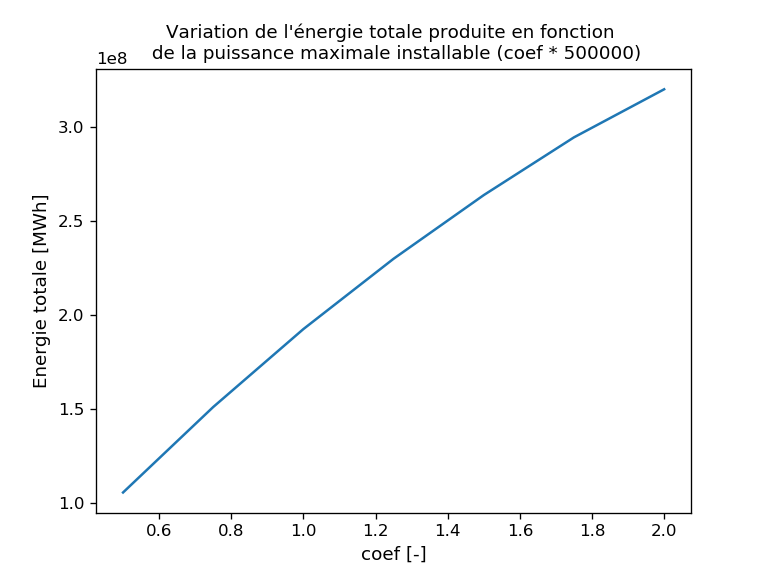

In [36]:
steps = 7
coef = np.linspace(0.5,2,steps)
puiss = np.zeros(steps)
for i in range (steps):
    puiss[i] = attribution_puissance(500000*coef[i])[1]

plt.plot(coef, puiss)
plt.title("Variation de l'énergie totale produite en fonction \n de la puissance maximale installable (coef * 500000)", fontsize=11)
plt.xlabel("coef [-]", fontsize=11)
plt.ylabel("Energie totale [MWh]", fontsize=11)

plt.show()

# Question I.5. a)

Admettons que nous n'imposions plus la contrainte :

$ \sum_{i=1}^{N_{sites}} p_{i}^{installées} = P $

Mais que nous la remplacions par :

$ \sum_{i=1}^{N_{sites}} p_{i}^{installées} \leq P $

Nous pourrions nous attendre à obtenir une solution au moins aussi bonne que dans notre cas d'origine. En effet, la contrainte d'égalité stricte étant plus forte, nous procéderions en fait à une relaxation de notre problème, or, la solution d'un problème relaxé est toujours au moins aussi bonne que celle de son problème d'origine.

Aussi, c'est ce que vérifie notre bout de code ci-dessous.

In [37]:
def attribution_puissance_variante1(P = 500000, kappa = 0.17, delta = 0.02, T = 3):
    s = CyClpSimplex()
    
    # Add variables
    x = s.addVariable('x', N_sites)
    
    # Add constraints
    p_max = CyLPArray(sites["capacites"])
    s += 0 <= x <= p_max
    
    s.addConstraint(x.sum() <= P,"contrainte puissance max")
    
    offshorearray = np.zeros(N_sites)
    offshorearray[indice_offshore] = 1             # set à 1 les sites offshore
    s.addConstraint((CyLPArray(offshorearray)*x) == kappa*P,"contrainte offshore")
    
    n_interval = N_heures//T  # nombre d'intervalle sur les heures imparties
    L = s.addVariable('l', n_interval-1) # vecteur L de longeur n_interval pour gérer valeurs absolues 
    
    sum = np.sum(rend_sites_matrix.copy().reshape(N_sites, n_interval, T), axis = 2)
    sum_shifted = sum.copy()
    sum_shifted = np.roll(sum, 1, axis = 1)
    sum = np.delete(sum, np.s_[0],  1)
    sum_shifted = np.delete(sum_shifted, np.s_[0],  1)
    diff = CyLPArray((sum_shifted - sum).transpose())
    
    s += diff*x - L <= 0
    s += -diff*x - L <= 0
    s.addConstraint(L.sum() <= delta*P*(n_interval-1)*T,"variabilité")  # contrainte de variabilité
    
    #print ("\nConstraints :\n", s.constraints)
    #print ("\nConstraintMatrix :\n", s.coefMatrix)
    
    # Set the objective function
    c = -CyLPArray(np.sum(rend_sites_matrix, axis = 1))
    
    s.objective = c * x
    #print("\nc = ",s.objective)
    
    # Solve using primal Simplex
    s.primal()
    
    dual_variable = s.dualVariableSolution["x"]

    dual_constraint = s.dualConstraintSolution
    
    # Return values
    return s.primalVariableSolution['x'], -s.objectiveValue, s.getStatusString(), s.primalVariableSolution['l'],dual_constraint,dual_variable
    
## Solutions ##

PUISSANCE_INSTALLEE1, ENERGIE_TOTALE1, type_sol1, l_sol1,dual_constraint1,dual_variable1 = attribution_puissance_variante1(500000,0.17,0.02,3)

print("\nEnergie totale_variante = ", ENERGIE_TOTALE1, "MWh") #192644543.2528026
#print("\nEtat de la solution ? = ", type_sol)

print("\nEnergie totale = ", ENERGIE_TOTALE, "MWh")

print("\nAugmentation de: ", (ENERGIE_TOTALE1/ENERGIE_TOTALE)*100 -100 ,"% par rapport au problème initial")


Energie totale_variante =  192644543.84691712 MWh

Energie totale =  192524556.90092024 MWh

Augmentation de:  0.06232293060600114 % par rapport au problème initial


Modifier la contrainte d'égalité de la puissance installée totale $ P $ en une borne supérieure revient à relaxer le problème. On observe donc une augmentation par rapport au problème initial, ce qui est bien conforme à nos attentes.

# Question I.5. b)

Considérons maintenant que nous n'imposons plus sur notre problème initial la contrainte :

$
\sum_{i=1}^{\frac{N_{heures}}{T}-1} \frac{\sum_{j=1}^{N}p_{j}^{installée}|\sum_{k=Ti+1}^{Ti+T} \eta_{jk}-\sum_{k=Ti+T+1}^{Ti+2T}\eta_{jk}|}{\frac{N_{heures}}{T}-1} \leq \delta P
$

Mais que nous la remplaçons par la nouvelle contrainte :

$
\text{max } ( \sum_{j=1}^{N}p_{j}^{installée}|\sum_{k=Ti+1}^{Ti+T} \eta_{jk}-\sum_{k=Ti+T+1}^{Ti+2T}\eta_{jk}| , i \in [1,\frac{N_{heures}}{T}-1] ) \leq \delta P
$

A l'inverse du point précédent, cette nouvelle contrainte est plus forte que celle d'origine, le problème est donc plus contraint que précédemment et nous nous attendons à ce que notre solution s'en trouve diminuée.

Aussi, c'est ce que confirme notre bout de code ci-dessous.

In [38]:
def attribution_puissance_variante2(P = 500000, kappa = 0.17, delta = 0.02, T = 3):
    s = CyClpSimplex()
    
    # Add variables
    x = s.addVariable('x', N_sites)
    
    # Add constraints
    p_max = CyLPArray(sites["capacites"])
    s += 0 <= x <= p_max
    
    s.addConstraint(x.sum() == P,"contrainte puissance max")
    
    offshorearray = np.zeros(N_sites)
    offshorearray[indice_offshore] = 1             # set à 1 les sites offshore
    s.addConstraint((CyLPArray(offshorearray)*x) == kappa*P,"contrainte offshore")
    
    n_interval = N_heures//T  # nombre d'intervalle sur les heures imparties
    L = s.addVariable('l', n_interval-1) # vecteur L de longeur n_interval pour gérer valeurs absolues 
    
    sum = np.sum(rend_sites_matrix.copy().reshape(N_sites, n_interval, T), axis = 2)
    sum_shifted = sum.copy()
    sum_shifted = np.roll(sum, 1, axis = 1)
    sum = np.delete(sum, np.s_[0],  1)
    sum_shifted = np.delete(sum_shifted, np.s_[0],  1)
    diff = CyLPArray((sum_shifted - sum).transpose())
    s += diff*x - L <= 0
    s += -diff*x - L <= 0
    s.addConstraint(np.array(L).max() <= delta*P,"variabilité")  # contrainte de variabilité
    
    #print ("\nConstraints :\n", s.constraints)
    #print ("\nConstraintMatrix :\n", s.coefMatrix)
    
    # Set the objective function
    c = -CyLPArray(np.sum(rend_sites_matrix, axis = 1))
    
    s.objective = c * x
    #print("\nc = ",s.objective)
    
    # Solve using primal Simplex
    s.primal()
    
    dual_variable = s.dualVariableSolution["x"]

    dual_constraint = s.dualConstraintSolution
    
    
    # Return values
    return s.primalVariableSolution['x'], -s.objectiveValue, s.getStatusString(), s.primalVariableSolution['l'],dual_constraint,dual_variable
    
## Solutions ##

PUISSANCE_INSTALLEE2, ENERGIE_TOTALE2, type_sol2, l_sol2,dual_constraint2,dual_variable2 = attribution_puissance_variante2(500000,0.17,0.02,3)

#print ("\nlsol = ",l_sol2) 
#print ("\nPuissance installée2 = ",PUISSANCE_INSTALLEE2) 
print("\nEnergie totale2 = ", ENERGIE_TOTALE2, "MWh") #192644543.2528026
#print("\nEtat de la solution2 ? = ", type_sol2)

print("\nEnergie totale = ", ENERGIE_TOTALE, "MWh")

print("\nDiminution de: ", (ENERGIE_TOTALE2/ENERGIE_TOTALE)*100 -100 ,"% par rapport au problème initial")


Energie totale2 =  84229021.81038766 MWh

Energie totale =  192524556.90092024 MWh

Diminution de:  -56.25024507718524 % par rapport au problème initial
